## 👋🛳️ Titanic Survival Prediction

we are going to take the following approach:
1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation



### 1. Problem Definition

> Given passenger data, can we predict whether or not they survived the sinking of the Titanic?
 

### 2. Data

The data is downloaded from the Kaggle Titanic Challenge: https://www.kaggle.com/c/titanic/data

### 3. Evaluation

You should submit a csv file with exactly 418 entries plus a header row. Your submission will show an error if you have extra columns (beyond PassengerId and Survived) or rows.
The file should have exactly 2 columns:

PassengerId (sorted in any order)

```
Survived (contains your binary predictions: 1 for survived, 0 for deceased)
PassengerId,Survived
892,0
893,1
894,0
Etc.
```

### 4. Features

**Data Dictionary**

**Variable**|**Definition**|**Key**
:-----:|:-----:|:-----:
survival|Survival|0 = No, 1 = Yes
pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd
sex|Sex| 
Age|Age in years| 
sibsp|# of siblings / spouses aboard the Titanic| 
parch|# of parents / children aboard the Titanic| 
ticket|Ticket number| 
fare|Passenger fare| 
cabin|Cabin number| 
**embarked**|**Port of Embarkation**|**C = Cherbourg, Q = Queenstown, S = Southampton**


**Variable Notes**
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower
age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)
parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load modal 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Load evaluation metrics

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,plot_roc_curve

# Load train test split

from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

In [122]:
# import data

df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [5]:
# Check the shape of the data

df_train.shape, df_test.shape



((891, 12), (418, 11))

## Data exploration (exploratory data analysis or EDA)

The goal here is to find out more about the data and become a subject matter export on the dataset you're working with.

1. What question(s) are you trying to solve?
2. What kind of data do we have and how do we treat different types?
3. What's missing from the data and how do you deal with it?
4. Where are the outliers and why should you care about them?
5. How can you add, change or remove features to get more out of your data?

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


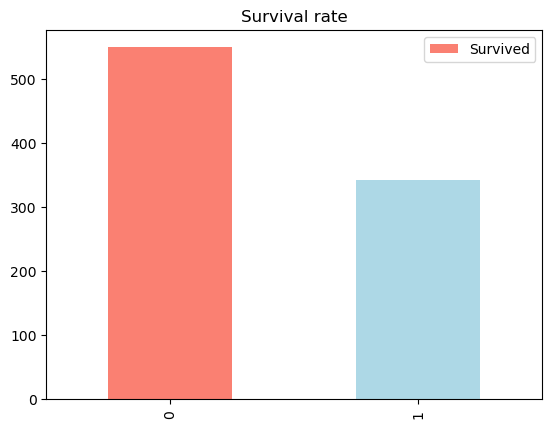

In [13]:
# lets find the survival rate

df_train['Survived'].value_counts().T.plot(kind='bar',color=['salmon','lightblue'],legend=True ,title='Survival rate');

## Survival Rate according to the pclass 

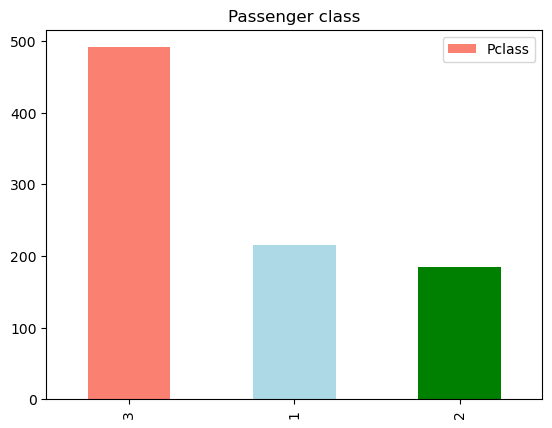

In [24]:
df_train['Pclass'].value_counts().T.plot(kind='bar',color=['salmon','lightblue','green'],legend=True ,title='Passenger class');

In [26]:
pd.crosstab(df_train['Survived'],df_train['Pclass']) 

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


In [106]:
# percent of Gender
women = df_train.loc[df_train.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)


men=df_train.loc[df_train.Sex == "male"]["Survived"]

rate=sum(men)/len(men)

print(f"Survival Rate of Male is : {rate*100:0.2f}")
print(f"Survival Rate of Woman is : {rate_women*100:0.2f}")



Survival Rate of Male is : 18.89
Survival Rate of Woman is : 74.20


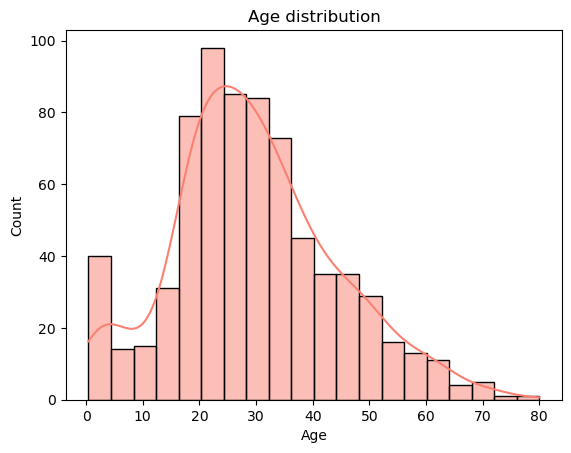

In [33]:
sns.histplot(df_train['Age'],bins=20,kde=True,color='salmon');
plt.title('Age distribution');

## Building a correlation matrix

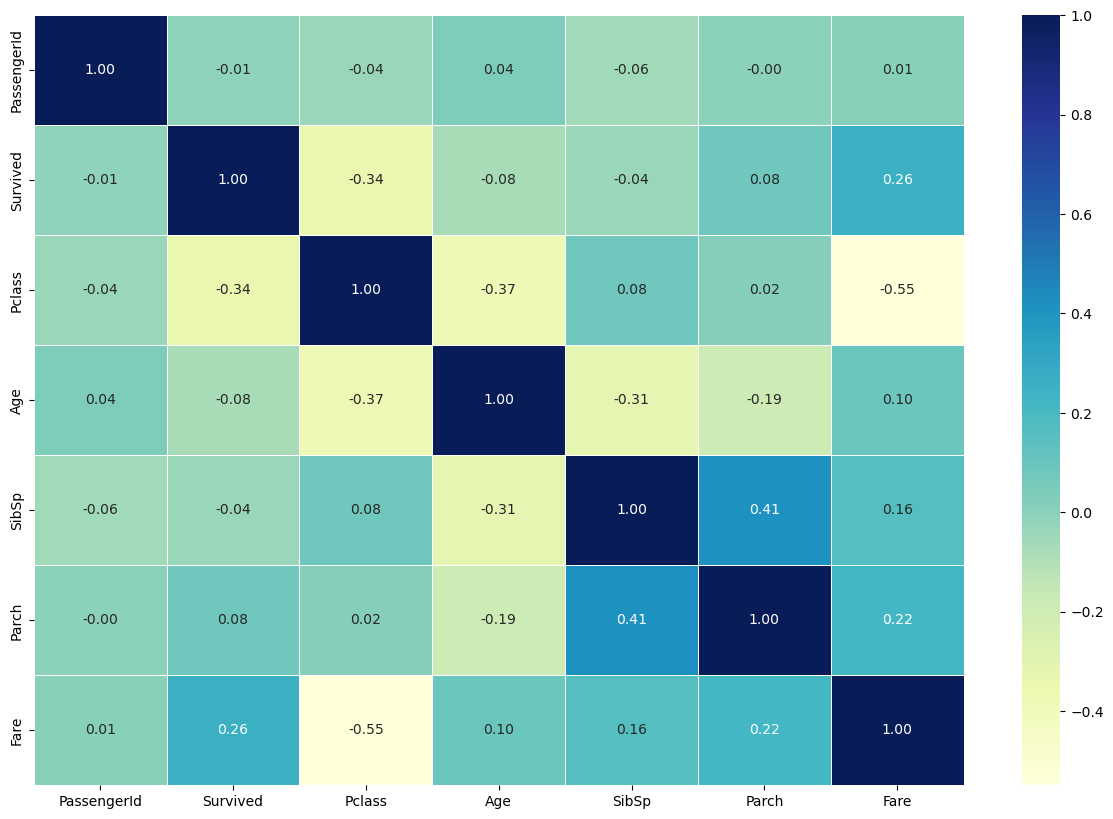

In [35]:
# let us plot the correlation matrix

corr_matrix=df_train.corr()

fig,ax=plt.subplots(figsize=(15,10))

ax=sns.heatmap(corr_matrix,annot=True,linewidths=0.5,fmt='.2f',cmap='YlGnBu');



In [171]:
# cover the categorical variables into numerical variables
from sklearn.preprocessing import LabelEncoder
encoding = LabelEncoder();
def preProcessData(df):
    # Cabin drop
    # df.drop("Cabin",axis=1,inplace=True)
    # sex to [0,1]
    df["Sex"]=encoding.fit_transform(df["Sex"])

    # Embarked to [0,1,2]
    df["Embarked"]=encoding.fit_transform(df["Embarked"])

    # # Embarked null values
    # df["Embarked"].fillna(df["Embarked"].mode()[0],inplace=True)

    

    # # for age we will fill the null values with median according to Embarked 

    # # for Embarked = 0
    df.loc[(df["Age"].isnull()) & (df["Embarked"]==0),"Age"]=df.loc[df["Embarked"]==0,"Age"].median()

    # # for Embarked = 1

    df.loc[(df["Age"].isnull()) & (df["Embarked"]==1),"Age"]=df.loc[df["Embarked"]==1,"Age"].median()

    # # for Embarked = 2

    df.loc[(df["Age"].isnull()) & (df["Embarked"]==2),"Age"]=df.loc[df["Embarked"]==2,"Age"].median()


    for label,content in df.items():
        # for string
        if pd.api.types.is_string_dtype(content):
            df[label]=content.astype("category").cat.as_ordered()
            df[label]=pd.Categorical(content).codes+1

    # for null values
    for label,content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label]=content.fillna(content.median())

# preProcessData for train data and test data

preProcessData(df_train)
preProcessData(df_test)

# df_train.info()

            

Now we have got our data split into training and test sets, it's time to build a machine learning model.

We'll train it (find the patterns) on the training set.

And we'll test it (use the patterns) on the test set.

1. Logistic Regression - LogisticRegression()
2. K-Nearest Neighbours - KNeighboursClassifier()
3. RandomForest - RandomForestClassifier()

In [187]:

x=df_train.drop(["Survived"],axis=1)
y = df_train["Survived"]
 

# split the data into train and test

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [188]:
def model_scores(models):
    np.random.seed(42)
    model_scores={}

    for label,model in models.items():
        model.fit(x_train,y_train)
        model_scores[label]=model.score(x_test,y_test)
       
    
    return model_scores


models={'Logistic Regression':LogisticRegression(),
        'KNN':KNeighborsClassifier(),
        'Random Forest':RandomForestClassifier()}



In [189]:


# model selection

models = {
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier()
}


model_scores = model_scores(models)

model_scores


/Volumes/Project/software/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Volumes/Project/software/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Se

{'Logistic Regression': 0.7877094972067039,
 'KNN': 0.664804469273743,
 'Random Forest': 0.8324022346368715}

In [192]:
# predict
y_preds = models["Random Forest"].predict(df_test)

# save the predictions

df_preds = pd.DataFrame({
    "PassengerId": df_test["PassengerId"],
    "Survived": y_preds

})


df_preds.to_csv("data/predictions.csv",index=False)



In [183]:
# Hyperparameter tuning

# RandomForestClassifier

rf_grid = {
    "n_estimators": np.arange(10,1000,50),
    "max_depth": [None,3,5,10],
    "min_samples_split": np.arange(2,20,2),

    "min_samples_leaf": np.arange(1,20,2),

    "max_features": [0.5,1,"sqrt","auto"],

}

# RandomizedSearchCV

rs_model = RandomizedSearchCV(RandomForestClassifier(),
                                param_distributions=rf_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

rs_model.fit(x_train,y_train)

rs_model.best_params_


Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'n_estimators': 460,
 'min_samples_split': 8,
 'min_samples_leaf': 5,
 'max_features': 0.5,
 'max_depth': 10}

In [163]:
rs_model.best_params_

{'n_estimators': 360,
 'min_samples_split': 8,
 'min_samples_leaf': 3,
 'max_features': 0.5,
 'max_depth': 10}

In [191]:

model=RandomForestClassifier(
    n_estimators=360,
    min_samples_split=8,
    min_samples_leaf=5,
    max_features=0.5,
    max_depth=10)

model.fit(x_train,y_train)

model.score(x_test,y_test)




0.8212290502793296

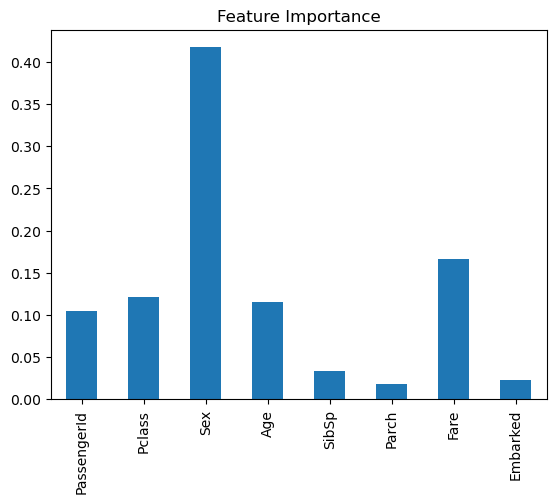

In [186]:
# Feature Importance

model.feature_importances_

feature_dict=dict(zip(x_train.columns,list(model.feature_importances_)))



feature_df=pd.DataFrame(feature_dict,index=[0])

feature_df.T.plot(kind='bar',legend=False,title='Feature Importance');

In [194]:
classification_report(y_test,model.predict(x_test))

'              precision    recall  f1-score   support\n\n           0       0.82      0.89      0.85       105\n           1       0.82      0.73      0.77        74\n\n    accuracy                           0.82       179\n   macro avg       0.82      0.81      0.81       179\nweighted avg       0.82      0.82      0.82       179\n'